<a href="https://colab.research.google.com/github/Furkan-Simsek/ai-with-tensorflow/blob/main/MileStoneProject1_FoodVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project: Food Vision Big

## Check GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-6ed858f0-bdbd-0850-2d14-6dc30f598ba4)


##Get helper Functions

In past modules, we've created a bunch of helper functiond to do small tasks required for our notebooks.

Rather than rewrite all of these, we can import a script aand load them in from there.

The script we've got available can be found on Github: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-07-26 10:29:35--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-26 10:29:35 (59.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data
In previous notebooks, we've downloaded our food images (from the Food101 dataset) from Google Storage.

And this is a typical workflow you'd use if you're working on your own datasets.

However, there's another way to get datasets ready to use with TensorFlow.

For many of the most popular datasets in the machine learning world (often referred to and used as benchmarks), you can access them through TensorFlow Datasets (TFDS).

What is **TensorFlow Datasets**?

A place for prepared and ready-to-use machine learning datasets.

Why use TensorFlow Datasets?

* Load data already in Tensors
* Practice on well established datasets
* Experiment with differet data loading techniques (like we're going to use in this notebook)
* Experiment with new TensorFlow features quickly (such as mixed precision training)

Why not use TensorFlow Datasets?

* The datasets are static (they don't change, like your real-world datasets would)
* Might not be suited for your particular problem (but great for experimenting)

To begin using TensorFlow Datasets we can import it under the alias `tfds`.

In [4]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [5]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is our target dataset in the list of tfds datasets?

True


In [6]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train","validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format (data,label)
                                             with_info=True
                                             )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteAJQEBY/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteAJQEBY/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from TensorFlow Datasets

To become one with our data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names?

In [7]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [8]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [15]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # Samples are in format (image_tensor, label)

In [17]:
# What does one sample of our training data look like
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [16]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image Shape: {image.shape},
  Image datatype: {image.dtype},
  Target class from Food101 (tensor form): {label},
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image Shape: (512, 512, 3),
  Image datatype: <dtype: 'uint8'>,
  Target class from Food101 (tensor form): 90,
  Class name (str form): spaghetti_bolognese
  


In [18]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 12,  13,   7],
        [ 12,  13,   7],
        [ 13,  14,   8],
        ...,
        [ 21,  11,   0],
        [ 21,  11,   0],
        [ 21,  11,   0]],

       [[ 12,  13,   7],
        [ 11,  12,   6],
        [ 11,  12,   6],
        ...,
        [ 21,  11,   0],
        [ 21,  11,   0],
        [ 21,  11,   0]],

       [[  7,   8,   2],
        [  7,   8,   2],
        [  7,   8,   2],
        ...,
        [ 22,  12,   2],
        [ 21,  11,   1],
        [ 20,  10,   0]],

       ...,

       [[188, 191, 184],
        [188, 191, 184],
        [188, 191, 184],
        ...,
        [243, 248, 244],
        [243, 248, 244],
        [242, 247, 243]],

       [[187, 190, 183],
        [189, 192, 185],
        [190, 193, 186],
        ...,
        [241, 245, 244],
        [241, 245, 244],
        [241, 245, 244]],

       [[186, 189, 182],
        [189, 192, 185],
        [191, 194, 187],
        ...,
        [238, 242, 24

In [19]:
# What are the min and max values our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow Datasets

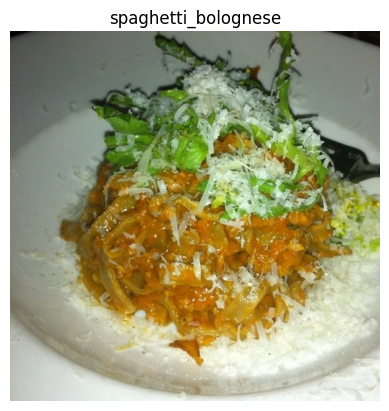

In [20]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Create preprocessing functions for our data

In previous notebooks, when our images were in folder format we used the method `tf.keras.preprocessing.image_dataset_from_directory()` to load them in.

Doing this meant our data was loaded into a format ready to be used with our models

However, since we've downloaded the data from TensorFlow Datasets, there are a couple of preprocessing steps we have t take before it's ready to model.

More specifiically, our data is currently:
* In `uint8` data type
* Comprised of all different sized tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

Whereas, models like data to be:
* In `float32` datatype
* Have all of the same size tensors (batches require all tensors have the same shape e.g. `(224,224,3)`)
* Scaled (values between 0 & 1), also called normalized

To take care of these, we'll create a `preprocess_img()` function which:
* Resizes an input image tensor to a specified size using `tf.image.resize`
* Converts an input image tensor's current datatype to `tf.float32` usiing `tf.cast()`

In [21]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to [img_shape,img_shape,img_shape,color_channels]
  """

  image = tf.image.resize(image, [img_shape,img_shape])
  return tf.cast(image, tf.float32), label

Our `preprocess_img()` function above takes image and label as input (even though it does nothing to the label) because our dataset is currently in the tuple structure `(image, label)`.

Let's try our function out on a target image.

In [22]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image,label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[12 13  7]
  [12 13  7]
  [13 14  8]
  ...
  [21 11  0]
  [21 11  0]
  [21 11  0]]

 [[12 13  7]
  [11 12  6]
  [11 12  6]
  ...
  [21 11  0]
  [21 11  0]
  [21 11  0]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[11.586735   12.586735    6.586735  ]
  [11.714286   12.714286    6.714286  ]
  [ 8.857142    9.857142    4.8571424 ]
  ...
  [20.714308   11.142836    1.2857144 ]
  [20.668371   10.668372    0.        ]
  [21.         11.          0.        ]]

 [[ 2.3571415   3.3571415   0.1428566 ]
  [ 3.1530607   4.153061    0.07653028]
  [ 3.0561223   4.0561223   0.        ]
  ...
  [26.071407   18.071407    7.0714073 ]
  [24.785702   14.785702    4.7857018 ]
  [22.499966   12.499966    2.4999657 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


Excellent! Looks like our `preprocess_img()` function is working as expected.

The input image gets converted from uint8 to float32 and gets reshaped from its current shape to `(224, 224, 3)`.

How does it look?

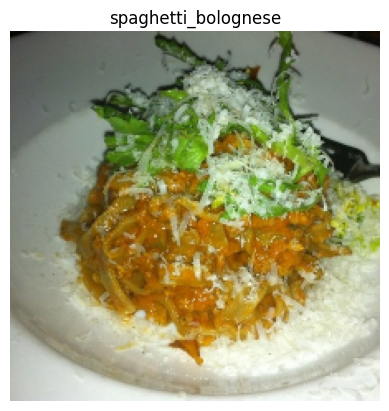

In [23]:
# We can still plot our preprocessed image as long as we
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);


## Batch & prepare datasets

Before we can model our data, we have to turn it into batches.

Why?

Because computing on batches is memory efficient.

We turn our data from 101,000 image tensors and labels (train and test combined) into batches of 32 image and label pairs, thus enabling it to fit into the memory of our GPU.

To do this in effective way, we're going to be leveraging a number of methods from the tf.data API.

📖 Resource: For loading data in the most performant way possible, see the TensorFlow docuemntation on Better performance with the tf.data API.

Specifically, we're going to be using:

map() - maps a predefined function to a target dataset (e.g. preprocess_img() to our image tensors)
shuffle() - randomly shuffles the elements of a target dataset up buffer_size (ideally, the buffer_size is equal to the size of the dataset, however, this may have implications on memory)
batch() - turns elements of a target dataset into batches (size defined by parameter batch_size)
prefetch() - prepares subsequent batches of data whilst other batches of data are being computed on (improves data loading speed but costs memory)
Extra: cache() - caches (saves them for later) elements in a target dataset, saving loading time (will only work if your dataset is small enough to fit in memory, standard Colab instances only have 12GB of memory)
Things to note:

* Can't batch tensors of different shapes (e.g. different image sizes, need to reshape images first, hence our `preprocess_img()` function)
* `shuffle()` keeps a buffer of the number you pass it images shuffled, ideally this number would be all of the samples in your training set, however, if your training set is large, this buffer might not fit in memory (a fairly large number like 1000 or 10000 is usually suffice for shuffling)
* For methods with the num_parallel_calls parameter available (such as `map()`), setting it `tonum_parallel_calls=tf.data.AUTOTUNE` will parallelize preprocessing and significantly improve speed
* Can't use `cache()` unless your dataset can fit in memory
Woah, the above is alot. But once we've coded below, it'll start to make sense.

We're going to through things in the following order:

`Original dataset (e.g. train_data) -> map() -> shuffle() -> batch() -> prefetch() -> PrefetchDataset`
This is like saying,

> "Hey, map this preprocessing function across our training dataset, then shuffle a number of elements before batching them together and make sure you prepare new batches (prefetch) whilst the model is looking through the current batch".

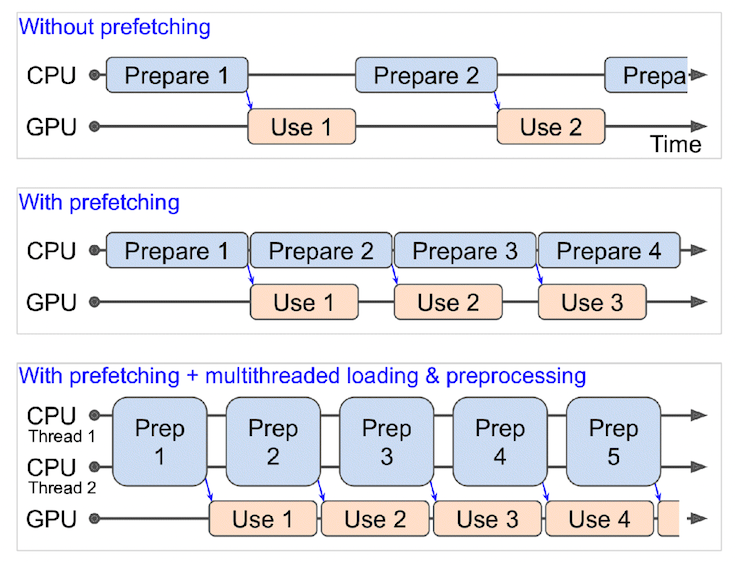

What happens when you use prefetching (faster) versus what happens when you don't use prefetching (slower). Source:* Page 422 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/).*

In [24]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [25]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

Excellent! Looks like our data is now in tutples of `(image, label)` with datatypes of `(tf.float32, tf.int64)`, just what our model is after.

> 🔑 Note: You can get away without calling the `prefetch()` method on the end of your datasets, however, you'd probably see significantly slower data loading speeds when building a model. So most of your dataset input pipelines should end with a call to `prefecth()`.


## Create modelling callbacks

Since we're going to be training on a large amount of data and training could take a long time, it's a good idea to set up some modelling callbacks so we be sure of things like our model's training logs being tracked and our model being checkpointed (saved) after various training milestones.

To do each of these we'll use the following callbacks:

* `tf.keras.callbacks.TensorBoard()` - allows us to keep track of our model's training history so we can inspect it later (**note**: we've created this callback before have imported it from `helper_functions.py` as `create_tensorboard_callback()`)
* `tf.keras.callbacks.ModelCheckpoint()` - saves our model's progress at various intervals so we can load it and resuse it later without having to retrain it
 * Checkpointing is also helpful so we can start fine-tuning our model at a particular epoch and revert back to a previous state if fine-tuning offers no benefits


In [40]:
# Create tenorboard callback (import from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create Model Checkpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     monitor="val_accuracy",
                                                     save_best_only=True,
                                                     save_weights_only=True,
                                                     verbose=0)

## Setup mixed precision training
We touched on mixed precision training above.

However, we didn't quite explain it.

Normally, tensors in TensorFlow default to the float32 datatype (unless otherwise specified).

In computer science, float32 is also known as single-precision floating-point format. The 32 means it usually occupies 32 bits in computer memory.

Your GPU has a limited memory, therefore it can only handle a number of float32 tensors at the same time.

This is where mixed precision training comes in.

Mixed precision training involves using a mix of float16 and float32 tensors to make better use of your GPU's memory.

Can you guess what float16 means?

Well, if you thought since float32 meant single-precision floating-point, you might've guessed float16 means half-precision floating-point format. And if you did, you're right! And if not, no trouble, now you know.

For tensors in float16 format, each element occupies 16 bits in computer memory.

So, where does this leave us?

As mentioned before, when using mixed precision training, your model will make use of float32 and float16 data types to use less memory where possible and in turn run faster (using less memory per tensor means more tensors can be computed on simultaneously).

As a result, using mixed precision training can improve your performance on modern GPUs (those with a compute capability score of 7.0+) by up to 3x.

For a more detailed explanation, I encourage you to read through the TensorFlow mixed precision guide (I'd highly recommend at least checking out the summary).

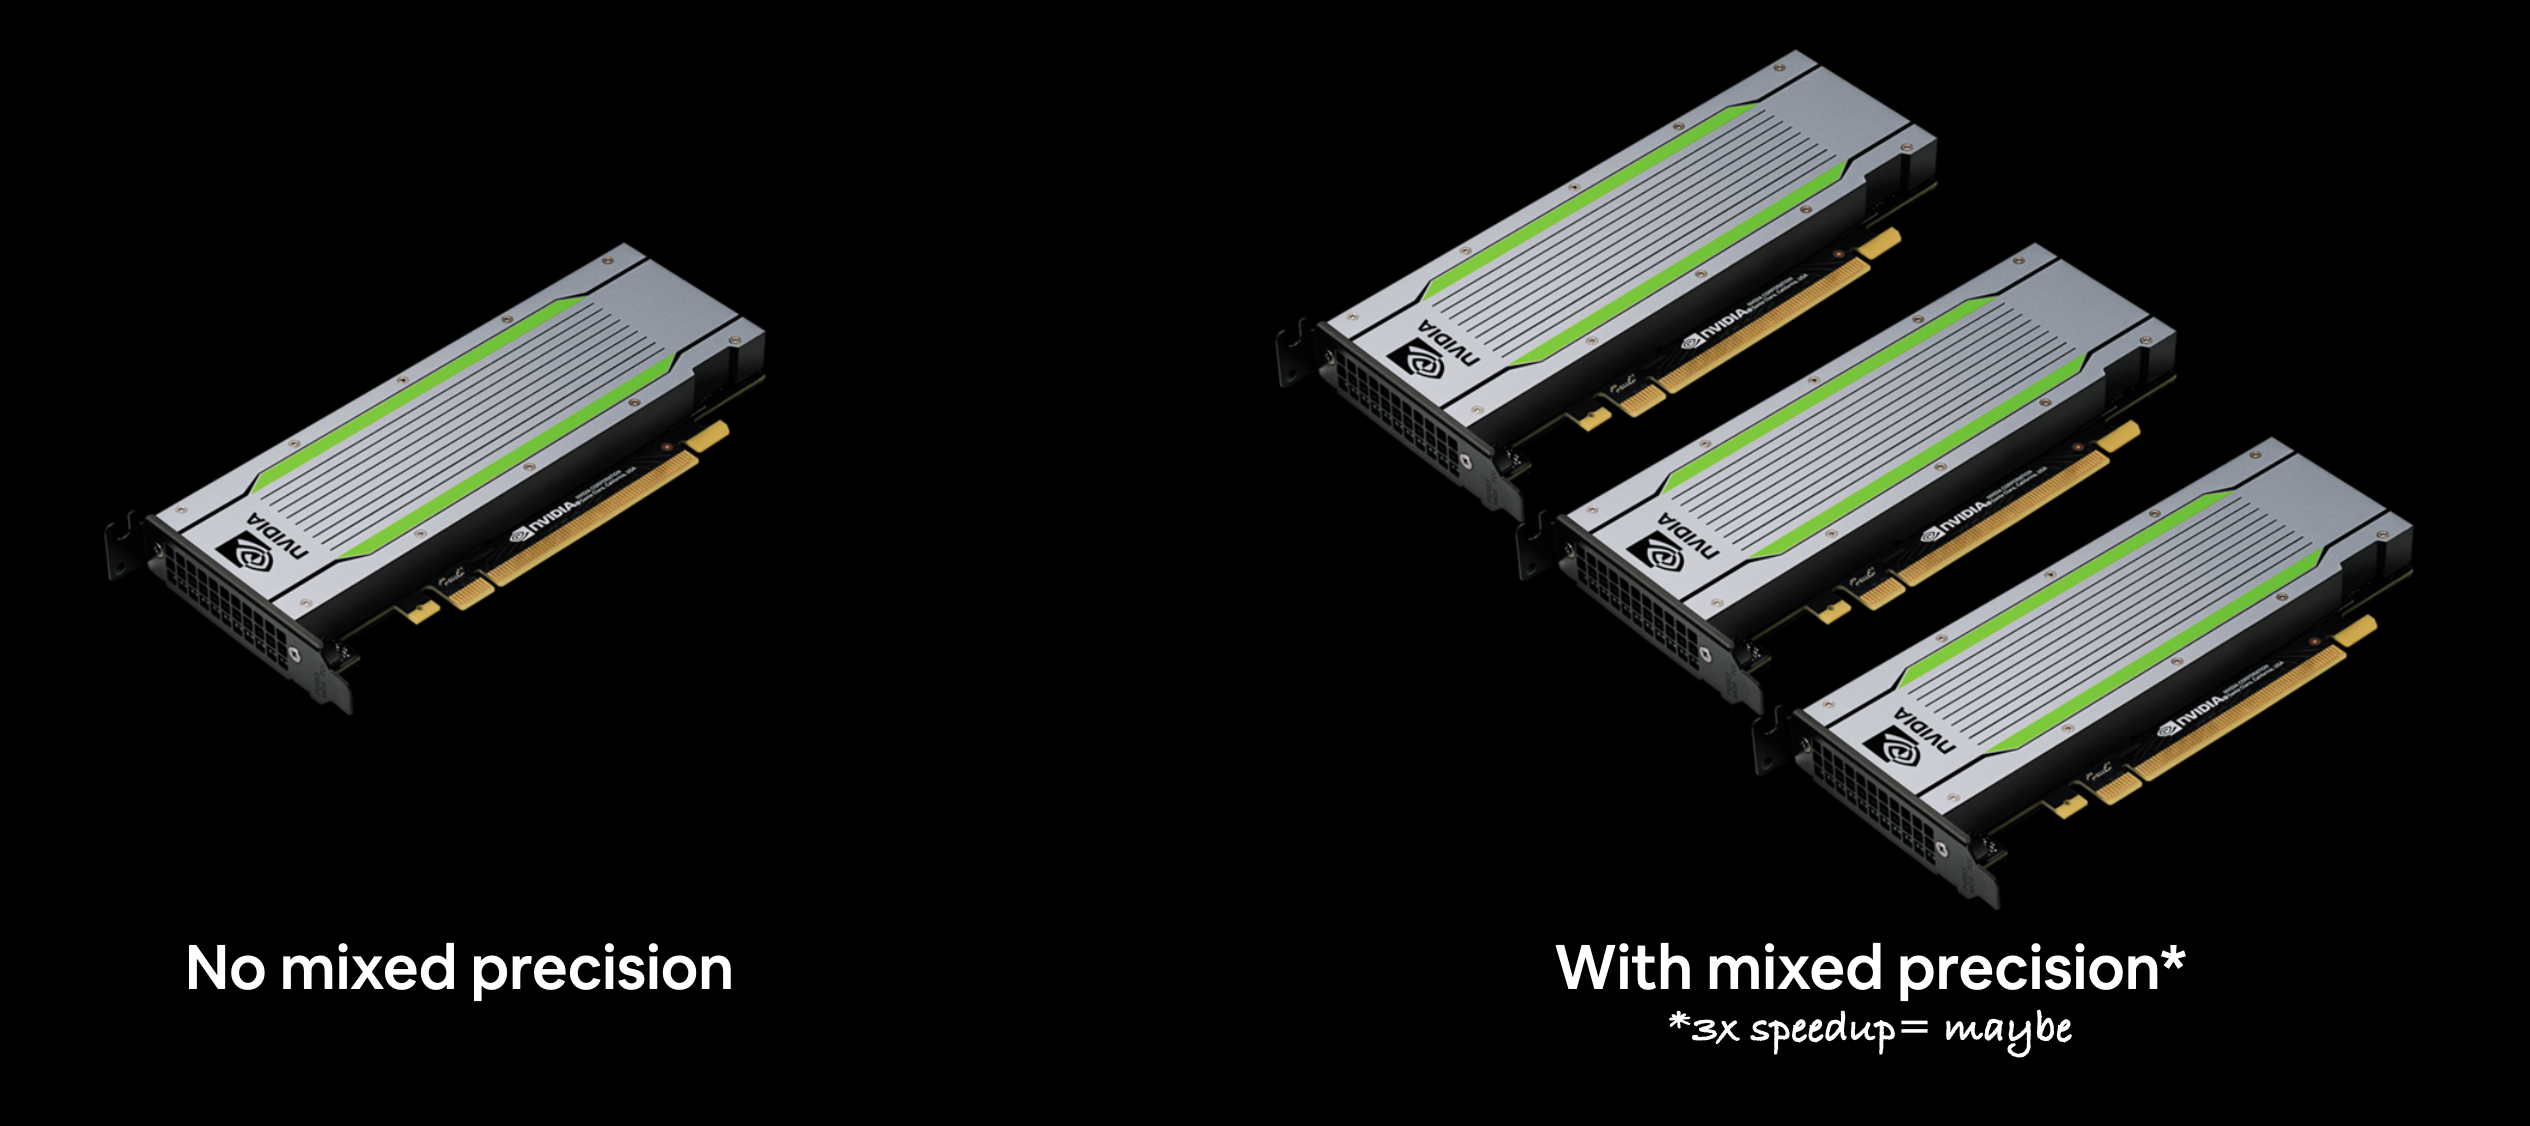

Because mixed precision training uses a combination of float32 and float16 data types, you may see up to a 3x speedup on modern GPUs.

> 🔑 Note: If your GPU doesn't have a score of over 7.0+ (e.g. P100 in Google Colab), mixed precision won't work (see: "Supported Hardware" in the mixed precision guide for more).

> 📖 Resource: If you'd like to learn more about precision in computer science (the detail to which a numerical quantity is expressed by a computer), see the Wikipedia page (and accompanying resources).


The beautiful thing is, the `tensorflow.keras.mixed_precision` API has made it very easy for us to get started.

First, we'll import the API and then use the `set_global_policy()` method to set the dtype policy to `"mixed_float16"`.

In [29]:
# turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision


In [30]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model

In [37]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Don't need in EfficientNetBX
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model = tf.keras.Model(inputs,outputs)

# Compile the model
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer  = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

In [38]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

### Checking layer dtype policies (are we using mixed precision?)

Model ready to go!

Before we said the mixed precision API will automatically change our layers' dtype policy's to whatever the global dtype policy is (in our case it's `"mixed_float16"`).

We can check this by iterating through our model's layers and printing layer attributes such as `dtype` and `dtype_policy`.

In [33]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:

* `layer.name (str)` : a layer's human-readable name, can be defined by the `name` parameter on construction
* `layer.trainable (bool)` : whether or not a layer is trainable (all of our layers are trainable except the efficientnetb0 layer since we set it's `trainable` attribute to `False`)
* `layer.dtype` : the data type a layer stores its variables in
* `layer.dtype_policy` : the data type a layer computes in
> 🔑 Note: A layer can have a dtype of float32 and a dtype policy of `"mixed_float16"` because it stores its variables (weights & biases) in `float32` (more numerically stable), however it computes in `float16` (faster).

We can also check the same details for our model's base model.

In [34]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <

> 🔑 Note: The mixed precision API automatically causes layers which can benefit from using the `"mixed_float16"` dtype policy to use it. It also prevents layers which shouldn't use it from using it (e.g. the normalization layer at the start of the base model).

## Fit the feature extraction model
Now that's one good looking model. Let's fit it to our data shall we?

Three epochs should be enough for our top layers to adjust their weights enough to our food image data.

To save time per epoch, we'll also only validate on 15% of the test data.

In [41]:
# Fit the feature extraction model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=(len(train_data)),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name= "training_logs",
                                                                                             experiment_name="efficientnetb0"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0/20230726-120033
Epoch 1/3
2368/2368 [==============================] - 207s 86ms/step - loss: 1.1305 - accuracy: 0.7055 - val_loss: 1.0056 - val_accuracy: 0.7180
Epoch 2/3
2368/2368 [==============================] - 203s 84ms/step - loss: 1.0100 - accuracy: 0.7348 - val_loss: 0.9786 - val_accuracy: 0.7296
Epoch 3/3
2368/2368 [==============================] - 202s 84ms/step - loss: 0.9268 - accuracy: 0.7564 - val_loss: 0.9817 - val_accuracy: 0.7278


Nice, looks like our feature extraction model is performing pretty well. How about we evaluate it on the whole test dataset?

In [42]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 70s 89ms/step - loss: 0.9853 - accuracy: 0.7306


[0.9853274822235107, 0.7306138873100281]